# Пример на данных QuickDraw 
https://github.com/googlecreativelab/quickdraw-dataset  
Используется урезанная версия с 16 классами 

In [34]:
import torch
from torch import flip
from torch.nn import Module
from torch import nn
from torch.nn.functional import conv2d
import torch.nn.functional as F
from torchvision.transforms.functional import resize, InterpolationMode
from einops import rearrange

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

import numpy as np
import math

import tqdm
from pprint import pprint, pformat
from IPython.display import display, clear_output
from pathlib import Path
import models
import inspect
import yaml
from PIL import Image

import time

### Параметры данных и модели

In [35]:
CONFIG = type('', (), {})() # object for parameters

CONFIG.model_class = models.OpticalSystemMLP
CONFIG.layers = 1
CONFIG.mlp_layers = 2
CONFIG.batch_size = 764//5
CONFIG.max_passes_through_dataset = 50
CONFIG.test_batch_size = 64

# свойства входных данных
CONFIG.dataset_name = 'quickdraw'
CONFIG.classes = 16
CONFIG.image_size = 28
CONFIG.train_class_instances = 8000
CONFIG.test_class_instances = 100
CONFIG.train_data_path = './assets/quickdraw16_train.npy'
CONFIG.test_data_path = './assets/quickdraw16_test.npy'

# свойства модели оптической системы
CONFIG.input_image_scale = 0.5
CONFIG.kernel_size_pixels = 28//2
CONFIG.tile_size_scale_factor = 1
CONFIG.resolution_scale_factor = 1 
CONFIG.class_slots = 16
CONFIG.wavelength = 532e-9
# CONFIG.refractive_index = 1.5090
CONFIG.propagation_distance = 300
CONFIG.metric = 1e-3
CONFIG.pixel_size_meters = 36e-6

CONFIG.name_id = f"{CONFIG.model_class.__name__}_{CONFIG.dataset_name}_{CONFIG.layers}_{CONFIG.mlp_layers}_{CONFIG.classes}_{CONFIG.max_passes_through_dataset}_{CONFIG.kernel_size_pixels}" + \
                 f"_{CONFIG.resolution_scale_factor}_{CONFIG.tile_size_scale_factor}_{CONFIG.input_image_scale}_{CONFIG.propagation_distance}_{CONFIG.wavelength}_{CONFIG.metric}_{CONFIG.pixel_size_meters}"
CONFIG.experiment_dir = Path(f'./experiments/{CONFIG.name_id}/')
CONFIG.experiment_dir.mkdir(parents=True, exist_ok=True)
CONFIG.model_path = CONFIG.experiment_dir / f"{CONFIG.name_id}.pt"
CONFIG.loss_plot_path = CONFIG.experiment_dir / f"{CONFIG.name_id}_loss.png"

yaml.dump(CONFIG, open(CONFIG.experiment_dir / "config.yaml", 'w'))

def init_from_config(config):
    init_arg_names = list(inspect.signature(CONFIG.model_class).parameters.keys())
    return CONFIG.model_class(**{k:CONFIG.__dict__[k] for k in init_arg_names})

pprint(CONFIG.__dict__)

{'batch_size': 152,
 'class_slots': 16,
 'classes': 16,
 'dataset_name': 'quickdraw',
 'experiment_dir': PosixPath('experiments/OpticalSystemMLP_quickdraw_1_2_16_50_14_1_1_0.5_300_5.32e-07_0.001_3.6e-05'),
 'image_size': 28,
 'input_image_scale': 0.5,
 'kernel_size_pixels': 14,
 'layers': 1,
 'loss_plot_path': PosixPath('experiments/OpticalSystemMLP_quickdraw_1_2_16_50_14_1_1_0.5_300_5.32e-07_0.001_3.6e-05/OpticalSystemMLP_quickdraw_1_2_16_50_14_1_1_0.5_300_5.32e-07_0.001_3.6e-05_loss.png'),
 'max_passes_through_dataset': 50,
 'metric': 0.001,
 'mlp_layers': 2,
 'model_class': <class 'models.OpticalSystemMLP'>,
 'model_path': PosixPath('experiments/OpticalSystemMLP_quickdraw_1_2_16_50_14_1_1_0.5_300_5.32e-07_0.001_3.6e-05/OpticalSystemMLP_quickdraw_1_2_16_50_14_1_1_0.5_300_5.32e-07_0.001_3.6e-05.pt'),
 'name_id': 'OpticalSystemMLP_quickdraw_1_2_16_50_14_1_1_0.5_300_5.32e-07_0.001_3.6e-05',
 'pixel_size_meters': 3.6e-05,
 'propagation_distance': 300,
 'resolution_scale_factor': 1,
 'tes

### Служебные функции

In [36]:
from utils import imshow, pad_zeros, unpad_zeros, to_class_labels

### Подготовка данных

In [37]:
train_data = torch.tensor(np.load(CONFIG.train_data_path), dtype=torch.float32)
test_data = torch.tensor(np.load(CONFIG.test_data_path), dtype=torch.float32)
train_data = rearrange(train_data, "b (h w) -> b 1 h w", h=CONFIG.image_size, w=CONFIG.image_size)
test_data = rearrange(test_data, "b (h w) -> b 1 h w", h=CONFIG.image_size, w=CONFIG.image_size)
train_data = torch.nn.functional.interpolate(train_data, scale_factor=CONFIG.input_image_scale, mode='bicubic')
test_data = torch.nn.functional.interpolate(test_data, scale_factor=CONFIG.input_image_scale, mode='bicubic')
train_data.shape, test_data.shape

(torch.Size([128000, 1, 14, 14]), torch.Size([1600, 1, 14, 14]))

In [38]:
train_targets = torch.eye(CONFIG.classes).repeat_interleave(repeats=CONFIG.train_class_instances, dim=0)
test_targets = torch.eye(CONFIG.classes).repeat_interleave(repeats=CONFIG.test_class_instances, dim=0)

train_labels = torch.repeat_interleave(torch.arange(CONFIG.classes), CONFIG.train_class_instances)
test_labels = torch.repeat_interleave(torch.arange(CONFIG.classes), CONFIG.test_class_instances)

train_targets.shape, test_targets.shape

(torch.Size([128000, 16]), torch.Size([1600, 16]))

### Создание экземпляра модели, оптимизатора, функции потерь

In [39]:
model = init_from_config(CONFIG)

# comment to train from scratch
# if Path(CONFIG.model_path).exists():
#     model.load_state_dict(torch.load(CONFIG.model_path))
#     print("LOADED from checkpoint.")
    
model.eval()
model.cuda();

In [40]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3, weight_decay=0)

def get_lr(optimizer):
    return list(optimizer.param_groups)[0]['lr']

def set_lr(optimizer, passes_through_dataset):
    pass

loss_function = torch.nn.CrossEntropyLoss()

### Обучение

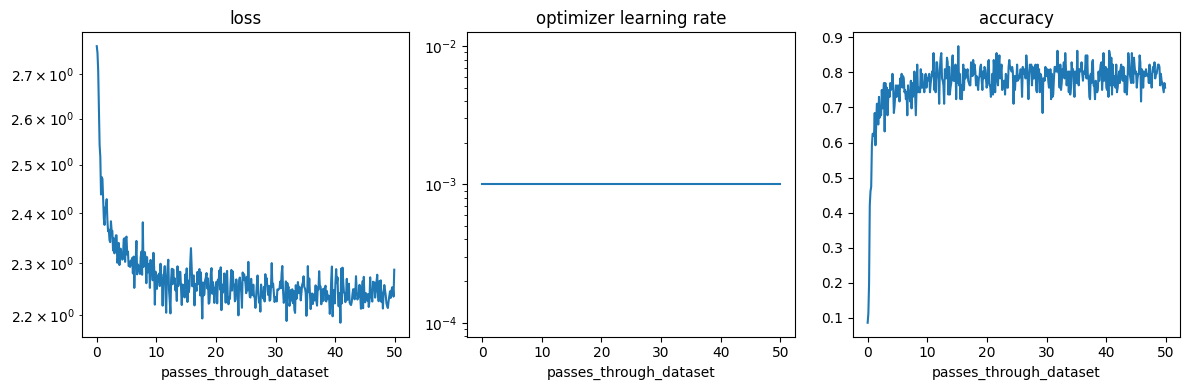

100%|██████████| 42105/42105 [02:02<00:00, 343.16it/s, loss: 2.246252e+00, acc: 0.80, lr: 1.000000e-03, passes_through_dataset: 49/50]


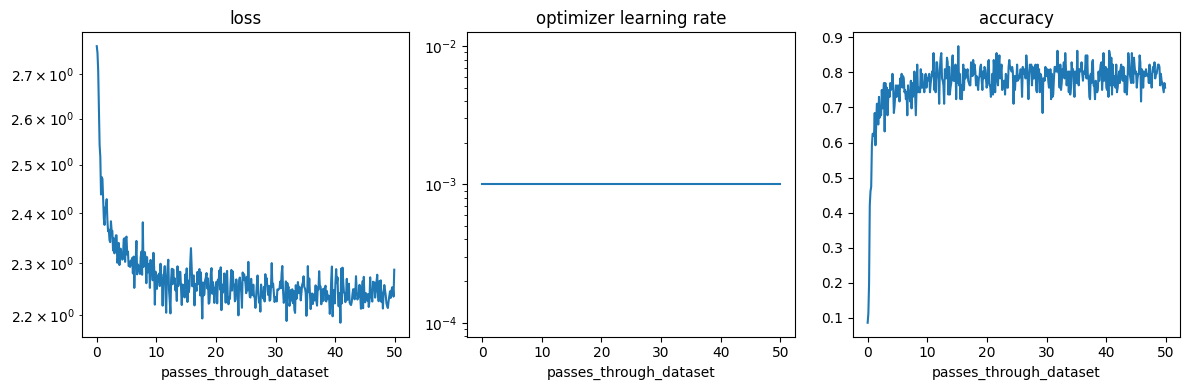

In [41]:
# training loop
epochs = int(train_data.shape[0]/CONFIG.batch_size*CONFIG.max_passes_through_dataset)
ppp = tqdm.trange(epochs)
loss_hist = []
weight_hist = []
acc_hist = []
f, (ax1, ax2, ax3)  = plt.subplots(1,3, figsize=(4*3,4))

def init_batch_generator(train_data, train_labels, batch_size):
    """
    Возвращает функцию, вызов которой возвращает следующие batch_size
    примеров и им соответствуюющих меток из train_data, train_labels.
    
    Примеры выбираются последовательно, по кругу. Массивы с входными 
    примерами и метками классов перемешиваются в начале каждого круга.
    """
    def f():
        i = 0
        rnd_indx = torch.randperm(train_data.shape[0])
        train_data_shuffled = train_data[rnd_indx]
        train_labels_shuffled = train_labels[rnd_indx]
        while True:
            if i + batch_size > train_data.shape[0]:
                i = 0
                rnd_indx = torch.randperm(train_data.shape[0])
                train_data_shuffled = train_data[rnd_indx]
                train_labels_shuffled = train_labels[rnd_indx]
                
            batch_inputs = train_data_shuffled[i:i+batch_size]
            batch_targets = train_labels_shuffled[i:i+batch_size]
            i = i + batch_size
            yield batch_inputs, batch_targets
    return f()

batch_iterator = init_batch_generator(train_data, train_targets, CONFIG.batch_size)
i = 0

for epoch in ppp:     
  batch_inputs, batch_targets = next(batch_iterator)
  batch_inputs = batch_inputs.cuda()
  batch_targets = batch_targets.cuda()
  i = i + CONFIG.batch_size
  passes_through_dataset = i//train_data.shape[0]
  # apply model
  predicted, convolved = model(batch_inputs)
  # correct model
  loss_value = loss_function(predicted, batch_targets)

  loss_value.backward()
  optimizer.step()

  # для небольших батчей следует уменьшать частоту вывода 
  if epoch % 100 == 0:
    acc = accuracy_score(to_class_labels(batch_targets), to_class_labels(predicted))
    ppp.set_postfix_str("loss: {:e}, acc: {:.2f}, lr: {:e}, passes_through_dataset: {}/{}".format(loss_value, acc, get_lr(optimizer), passes_through_dataset, CONFIG.max_passes_through_dataset))
    loss_hist.append(loss_value.item())   
    weight_hist.append(get_lr(optimizer))
    acc_hist.append(acc)
      
  if epoch % 1000 == 0 and epoch > 0:  
    vis_loss_hist = np.array(loss_hist)
    ax1.cla()
    ax2.cla()
    ax3.cla()
    ax1.plot(np.linspace(0, i, num=len(vis_loss_hist))/len(train_data), vis_loss_hist, label='aloss')
    ax1.set_xlabel('passes_through_dataset')
    ax1.set_yscale('log')
    ax1.set_title("loss")
    ax2.set_title("optimizer learning rate")
    ax2.set_xlabel('passes_through_dataset')
    ax2.set_yscale('log')      
    ax2.plot(np.linspace(0,  i, num=len(weight_hist))/len(train_data), weight_hist, label='lr')
    ax3.set_title("accuracy")
    ax3.set_xlabel('passes_through_dataset')
    ax3.plot(np.linspace(0,  i, num=len(acc_hist))/len(train_data), acc_hist, label='acc')
    clear_output(wait=True)
    f.tight_layout()
    display(f)
    f.savefig(CONFIG.loss_plot_path)

  set_lr(optimizer, passes_through_dataset)

### Тест

In [42]:
inputs = test_data
targets = test_targets

predicted = []
batch_start = 0
while batch_start < test_data.shape[0]:
    batch_end = min(batch_start + CONFIG.test_batch_size, test_data.shape[0])
    batch_input = inputs[batch_start:batch_end].cuda() 
    batch_output, _ = model(batch_input)
    predicted.append(batch_output.detach().cpu())
    batch_start = batch_end

predicted = torch.concat(predicted)

test_acc = accuracy_score(to_class_labels(targets), to_class_labels(predicted))
"Accuracy on test dataset: ", test_acc

('Accuracy on test dataset: ', 0.786875)

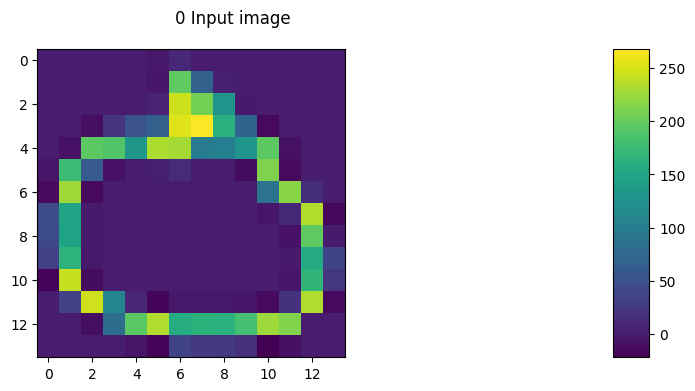

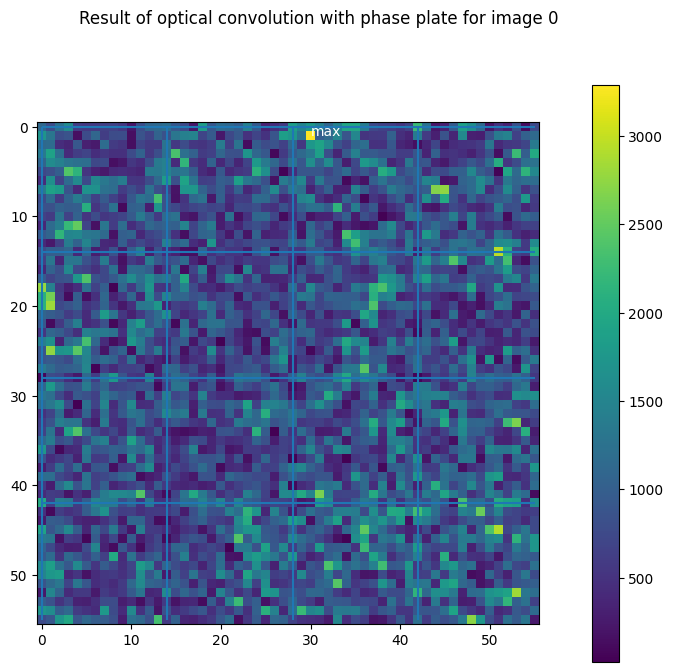

In [89]:
class_id = 0 
example_num = 2
image = test_data[test_labels==class_id][example_num:example_num+1]
imshow(image, title=f"Input image")
softmax, convolved = model(image.cuda())

for idx, psf in enumerate(convolved):
    psf = psf.squeeze().cpu()
    grid_to_depth = rearrange(
        psf,
        "(m ht) (n wt) -> (m n) ht wt",
        ht = model.tile_size*model.resolution_scale_factor,
        wt = model.tile_size*model.resolution_scale_factor,
        m = model.tiles_per_dim,
        n = model.tiles_per_dim
    )
    # 5
    grid_to_depth = unpad_zeros(
        grid_to_depth, 
        (model.kernel_size_pixels*model.resolution_scale_factor,  
         model.kernel_size_pixels*model.resolution_scale_factor))
    # 2
    grid_to_depth = pad_zeros(
        grid_to_depth, 
        size = (model.tile_size*model.resolution_scale_factor , 
                model.tile_size*model.resolution_scale_factor ),
    )
    grid_to_depth = rearrange(
        grid_to_depth,
        "(m n) ht wt -> (m ht) (n wt)",
        ht = model.tile_size*model.resolution_scale_factor,
        wt = model.tile_size*model.resolution_scale_factor,
        m = model.tiles_per_dim,
        n = model.tiles_per_dim
    )
    
    f, ax = imshow(grid_to_depth, figsize=(15*0.5,15*0.5), title=f"Result of optical convolution with phase plate for image {idx}")
    ax[0].hlines(np.arange(0, grid_to_depth.shape[0], grid_to_depth.shape[0]//model.tiles_per_dim), 0, psf.shape[1]-1)
    ax[0].vlines(np.arange(0, grid_to_depth.shape[1], grid_to_depth.shape[1]//model.tiles_per_dim), 0, psf.shape[0]-1)
    y,x = (psf==torch.max(grid_to_depth)).nonzero()[0]
    ax[0].text(x,y, "max", color='white');

### Сохранение рельефа

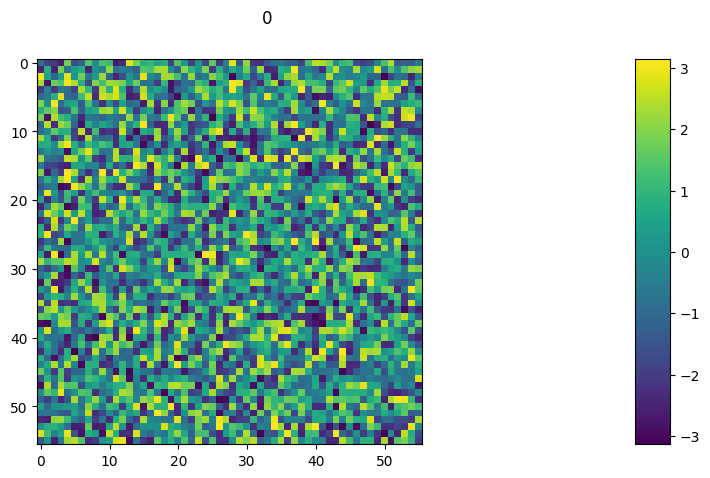

In [44]:
imshow([torch.log(x.cpu().detach()).imag for x in model.height_maps], figsize=(20*0.5,10*0.5));

In [45]:
for idx, heights in enumerate(model.height_maps):
    heights = heights.cpu().detach()
    heights = torch.log(heights).imag
    m = heights.abs().mean()
    s = heights.abs().std()
    m1, m2 = heights.abs().min(), heights.abs().max()
    ar = heights.numpy() 
    im = ar
    im = im - im.min()
    im = im / im.max()
    im = im * 255
    name_im = CONFIG.experiment_dir / (CONFIG.name_id + f"_phasemask_{idx}.png")
    name_np = CONFIG.experiment_dir / (CONFIG.name_id + f"_phasemask_{idx}")
    result = Image.fromarray(im.astype(np.uint8))
    result.save(name_im)
    np.save(name_np, ar)

In [19]:
torch.save(model.state_dict(), CONFIG.model_path)

In [46]:
time.sleep(121)
Path(CONFIG.experiment_dir / f"{CONFIG.name_id}.ipynb").write_bytes(Path("Propagator_QuickDraw.ipynb").read_bytes());

### Отладка

In [47]:
class_id = 0
image = test_data[test_labels==class_id][:1]
softmax, convolved, dbg = model.forward_debug(image.cuda())

torch.Size([1, 1, 14, 14]) (56, 56)
torch.Size([1, 16, 14, 14]) (14, 14)


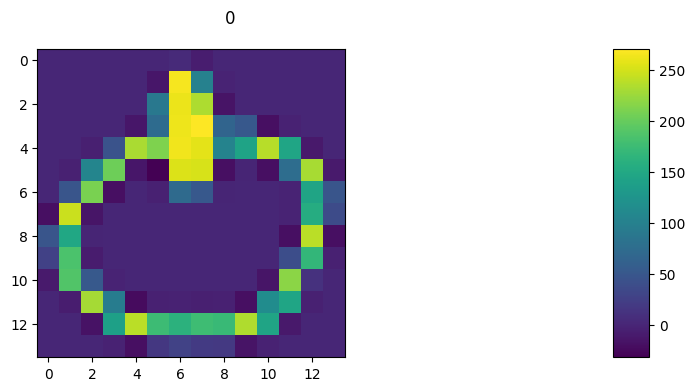

In [48]:
# resized input image
imshow(dbg[0]);

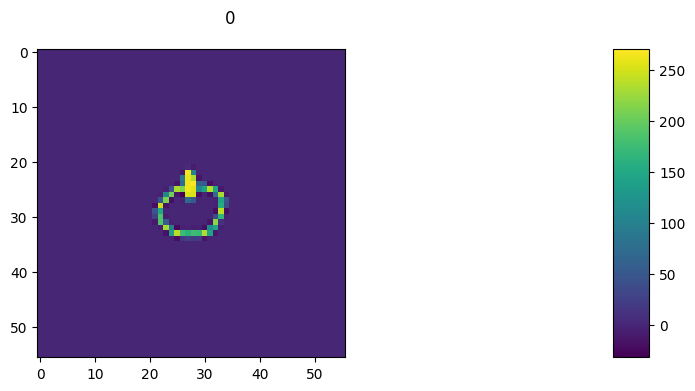

In [49]:
# padded input image
imshow(dbg[1]);

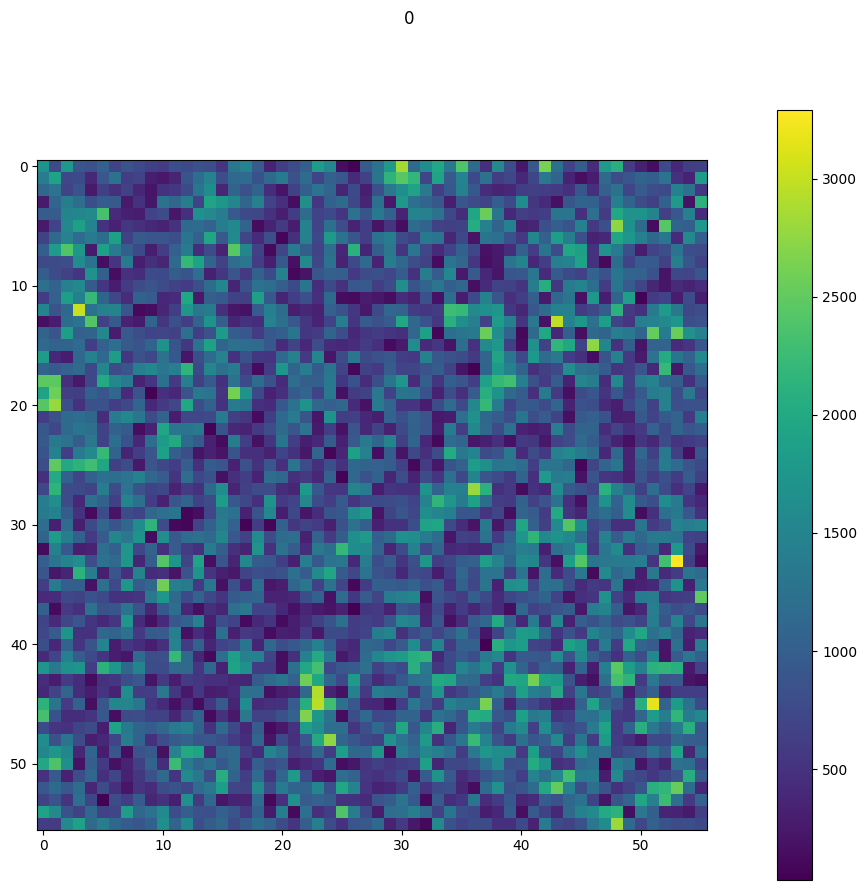

In [50]:
# convolution output image
imshow(dbg[2],figsize=(10,10));

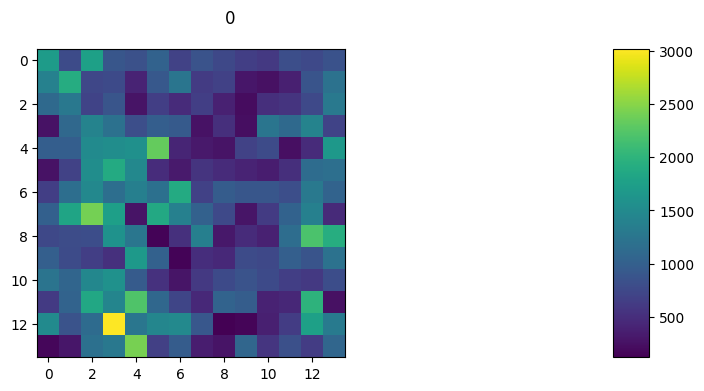

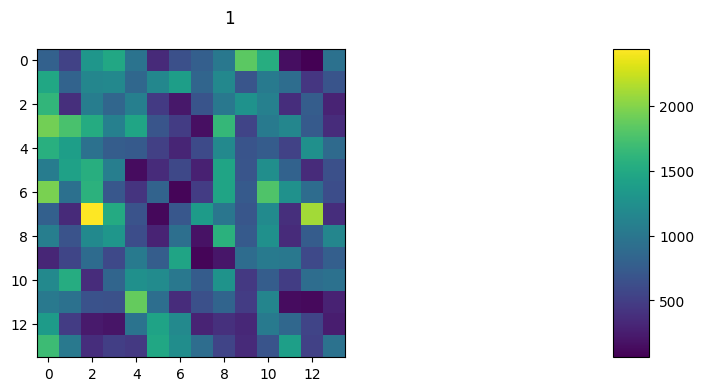

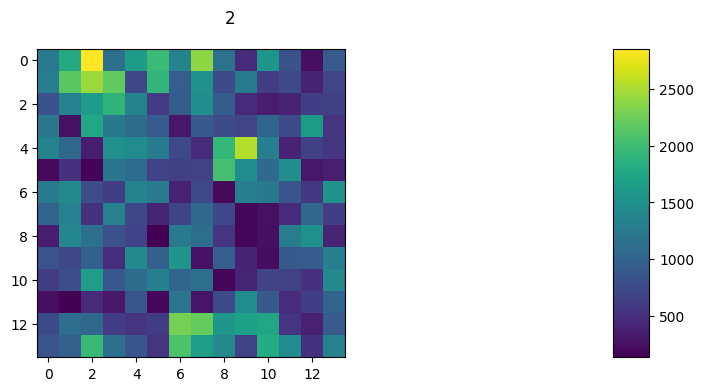

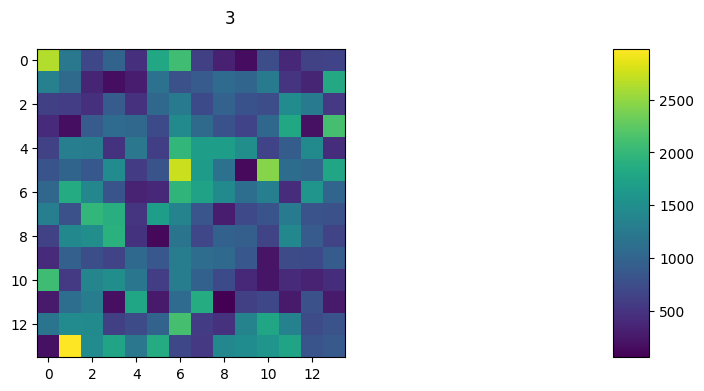

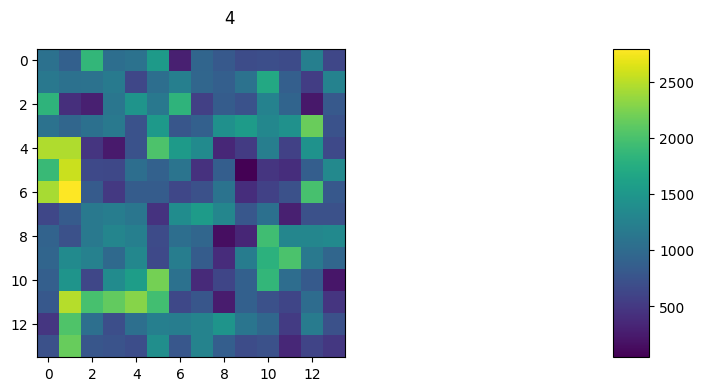

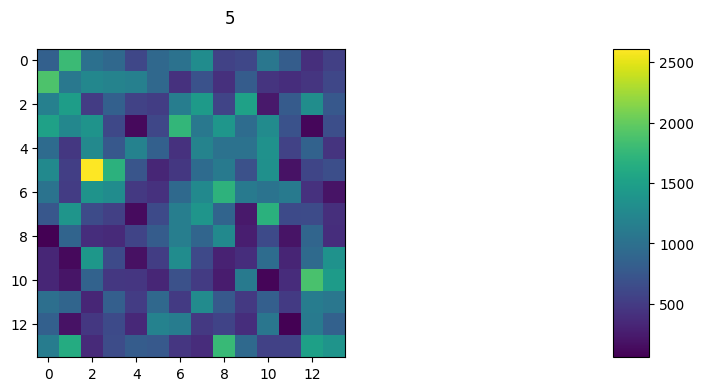

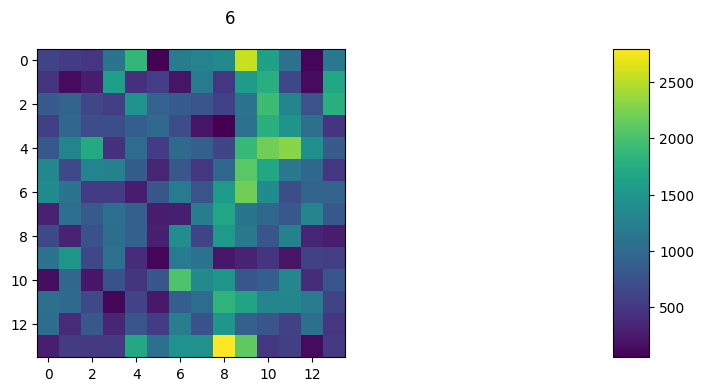

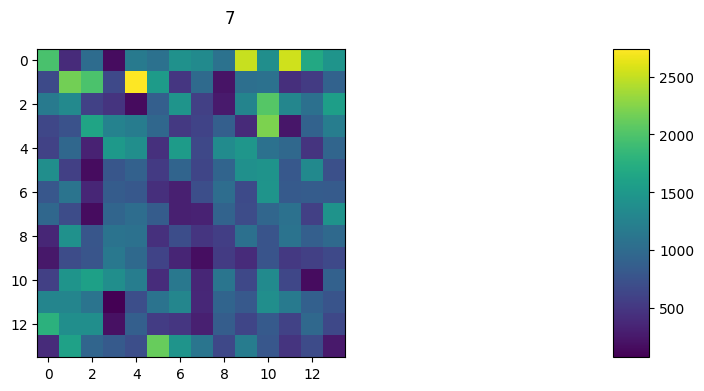

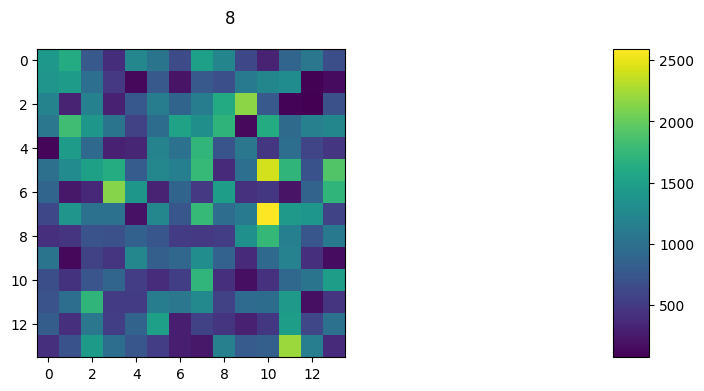

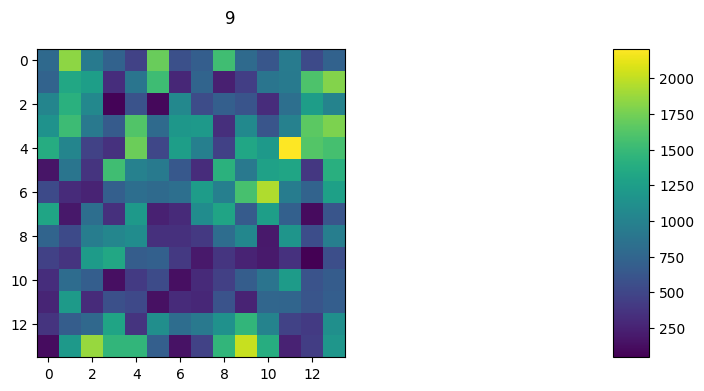

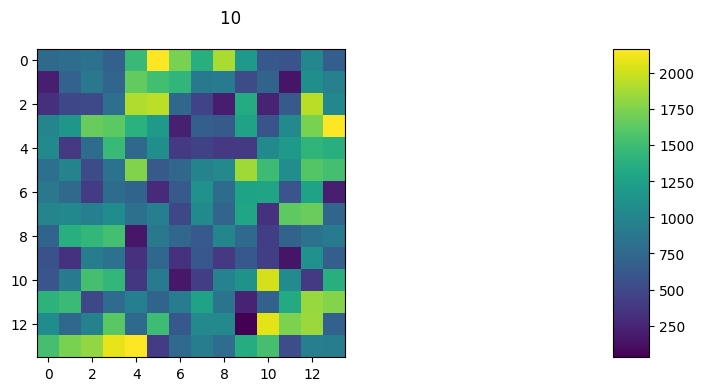

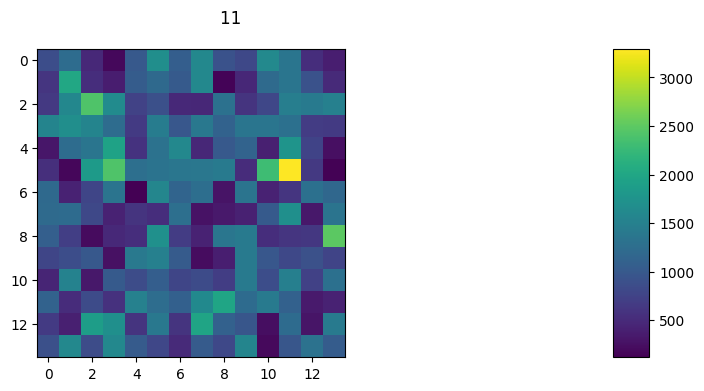

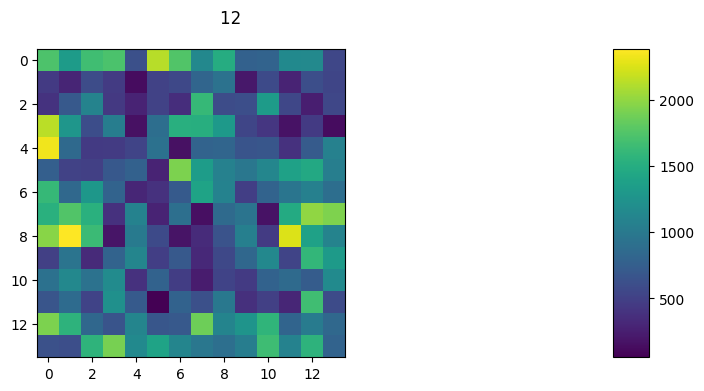

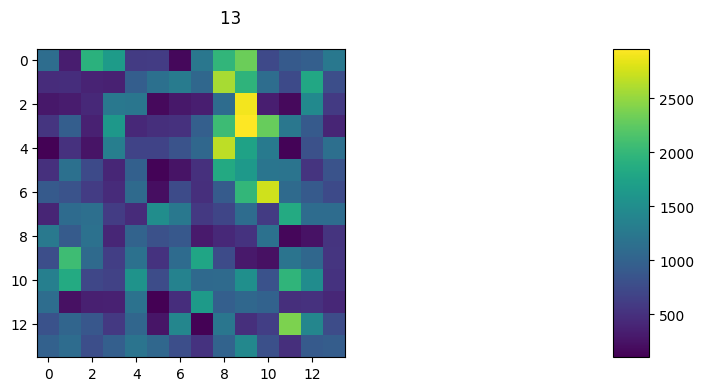

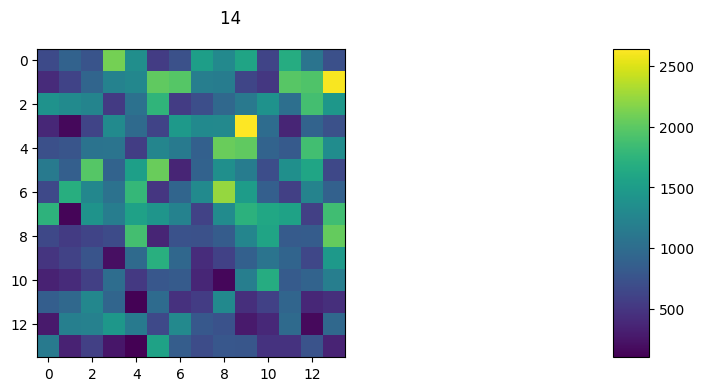

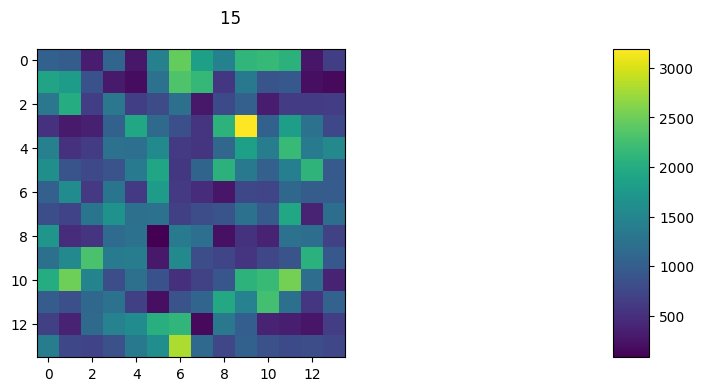

In [51]:
# grid as sequence of images
imshow([x for x in dbg[3].squeeze()]);

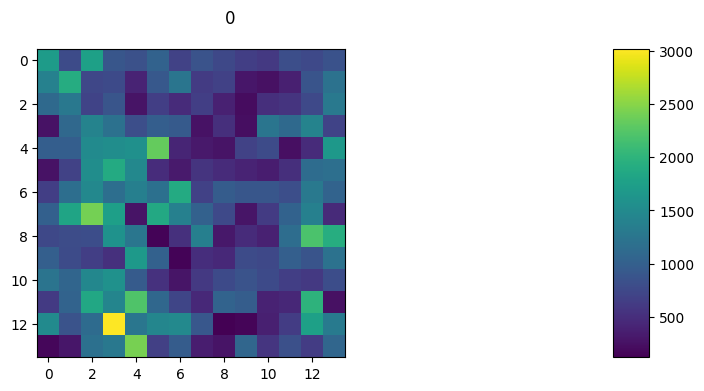

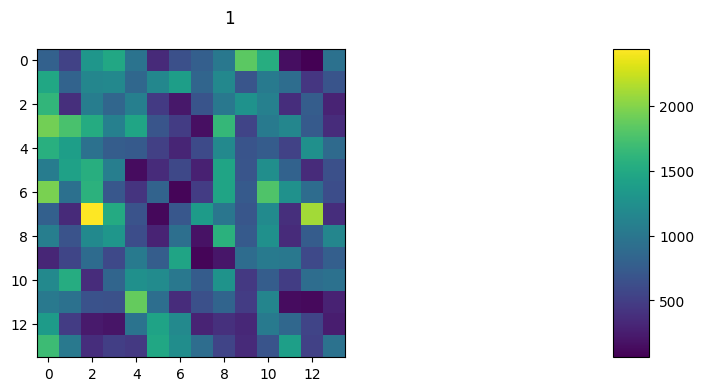

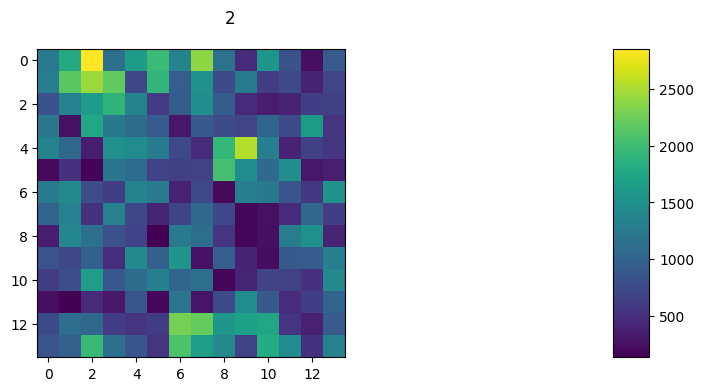

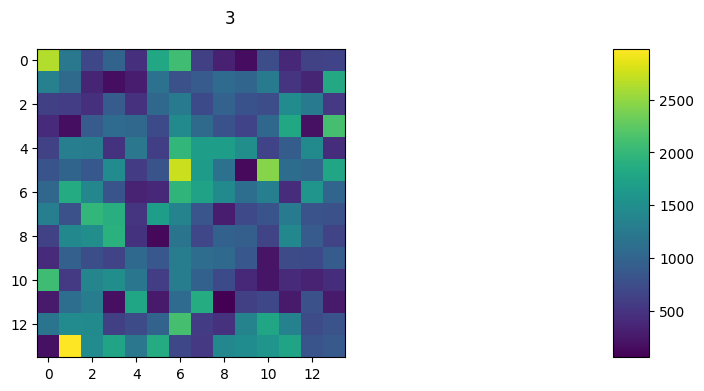

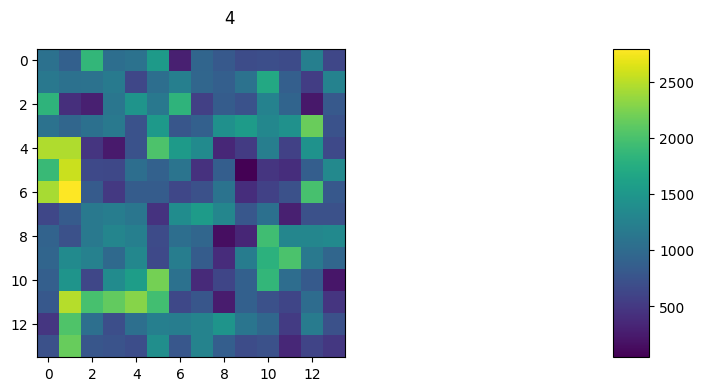

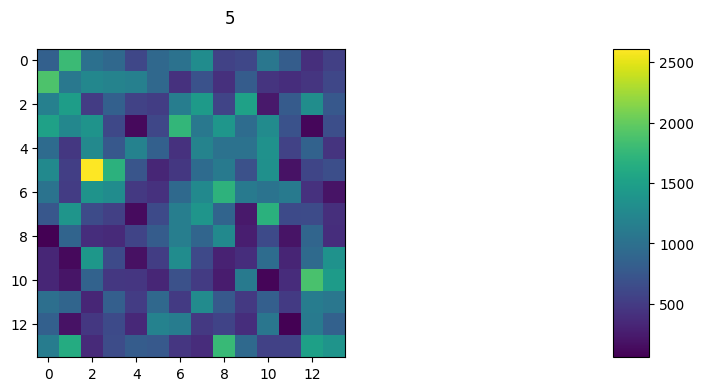

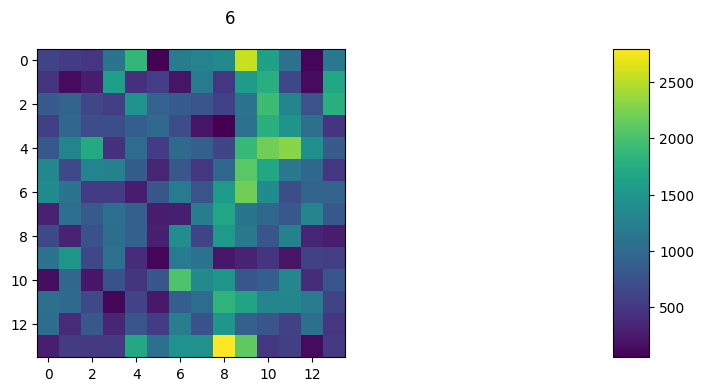

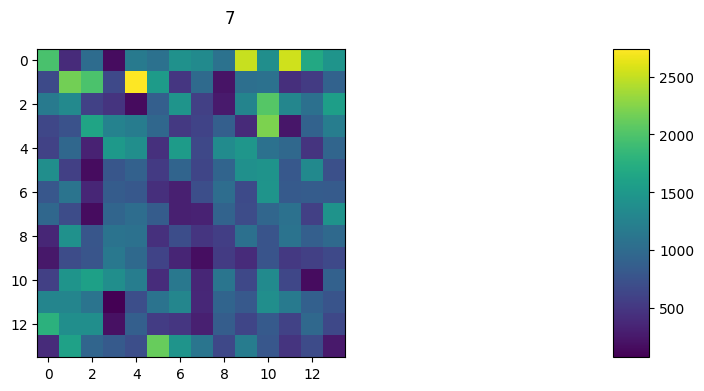

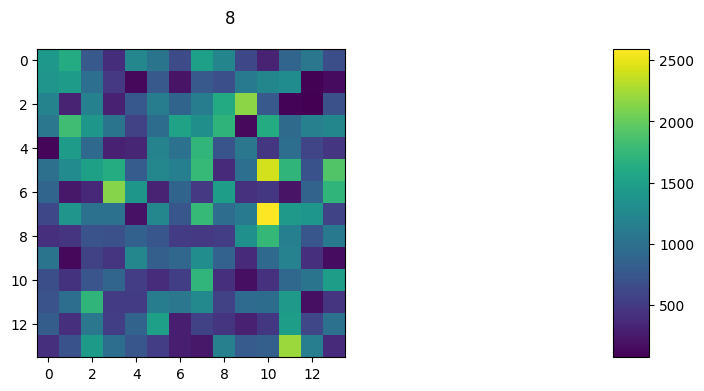

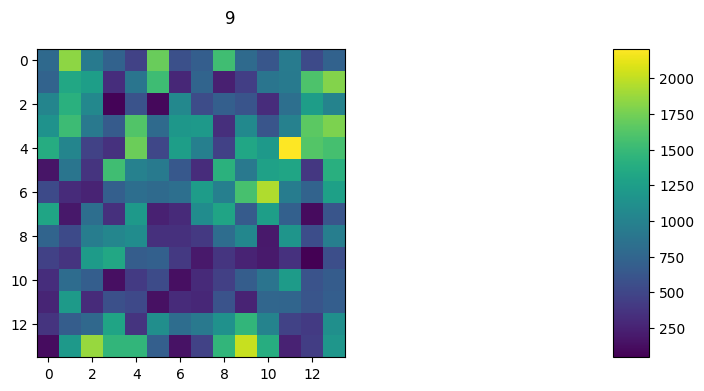

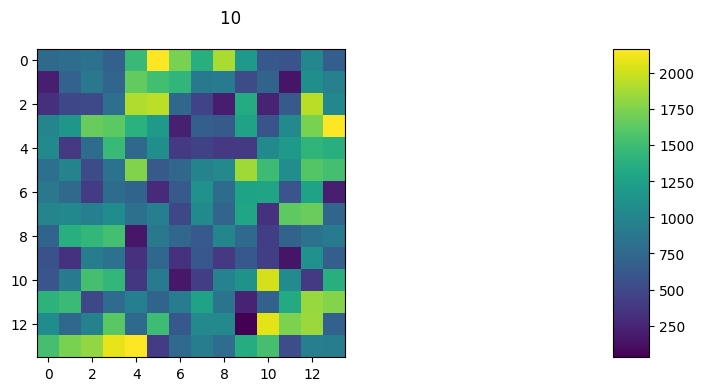

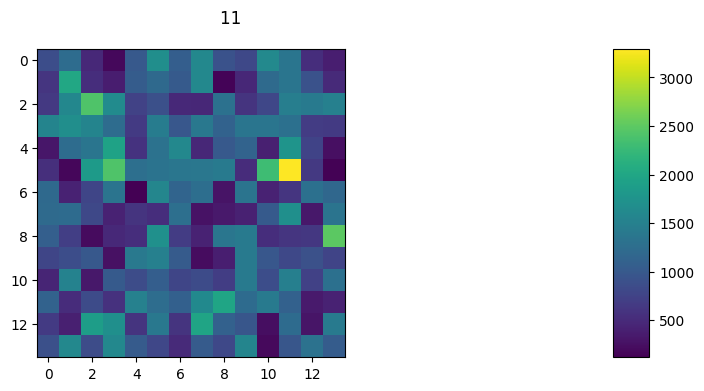

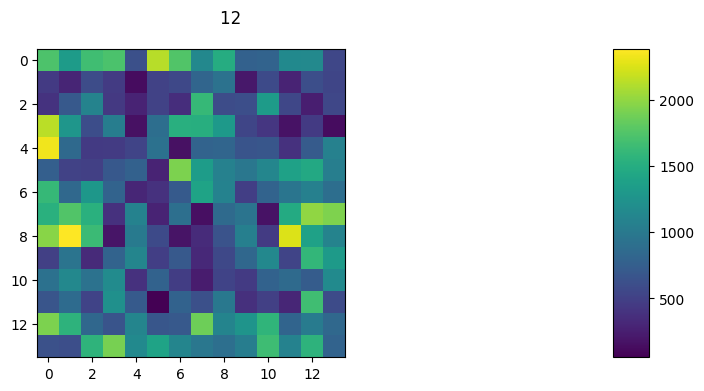

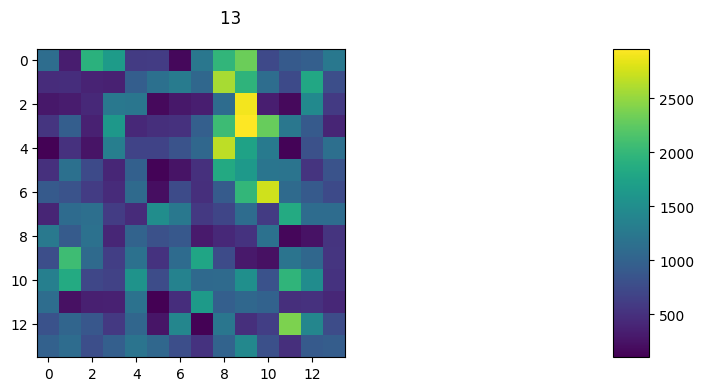

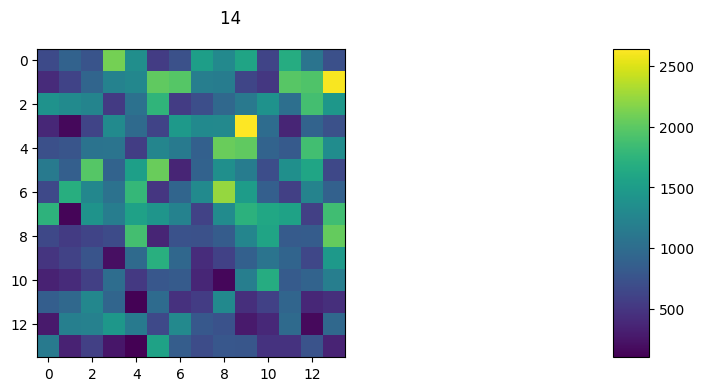

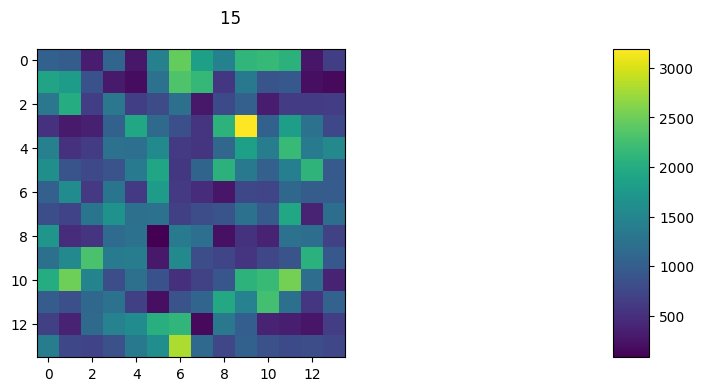

In [52]:
# grid as sequence of images, unpadded
imshow([x for x in dbg[4].squeeze()]);

<BarContainer object of 16 artists>

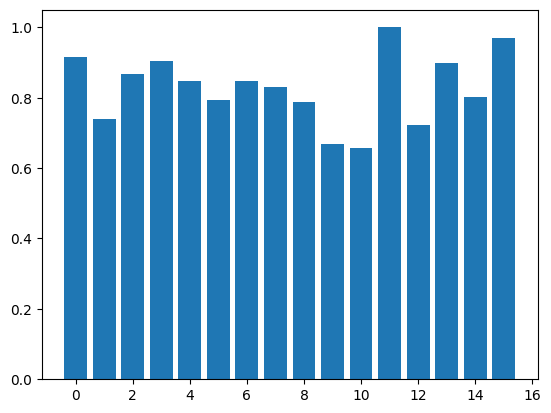

In [53]:
# max pool sequence
plt.bar(np.arange(CONFIG.class_slots), dbg[5].cpu().detach().squeeze())

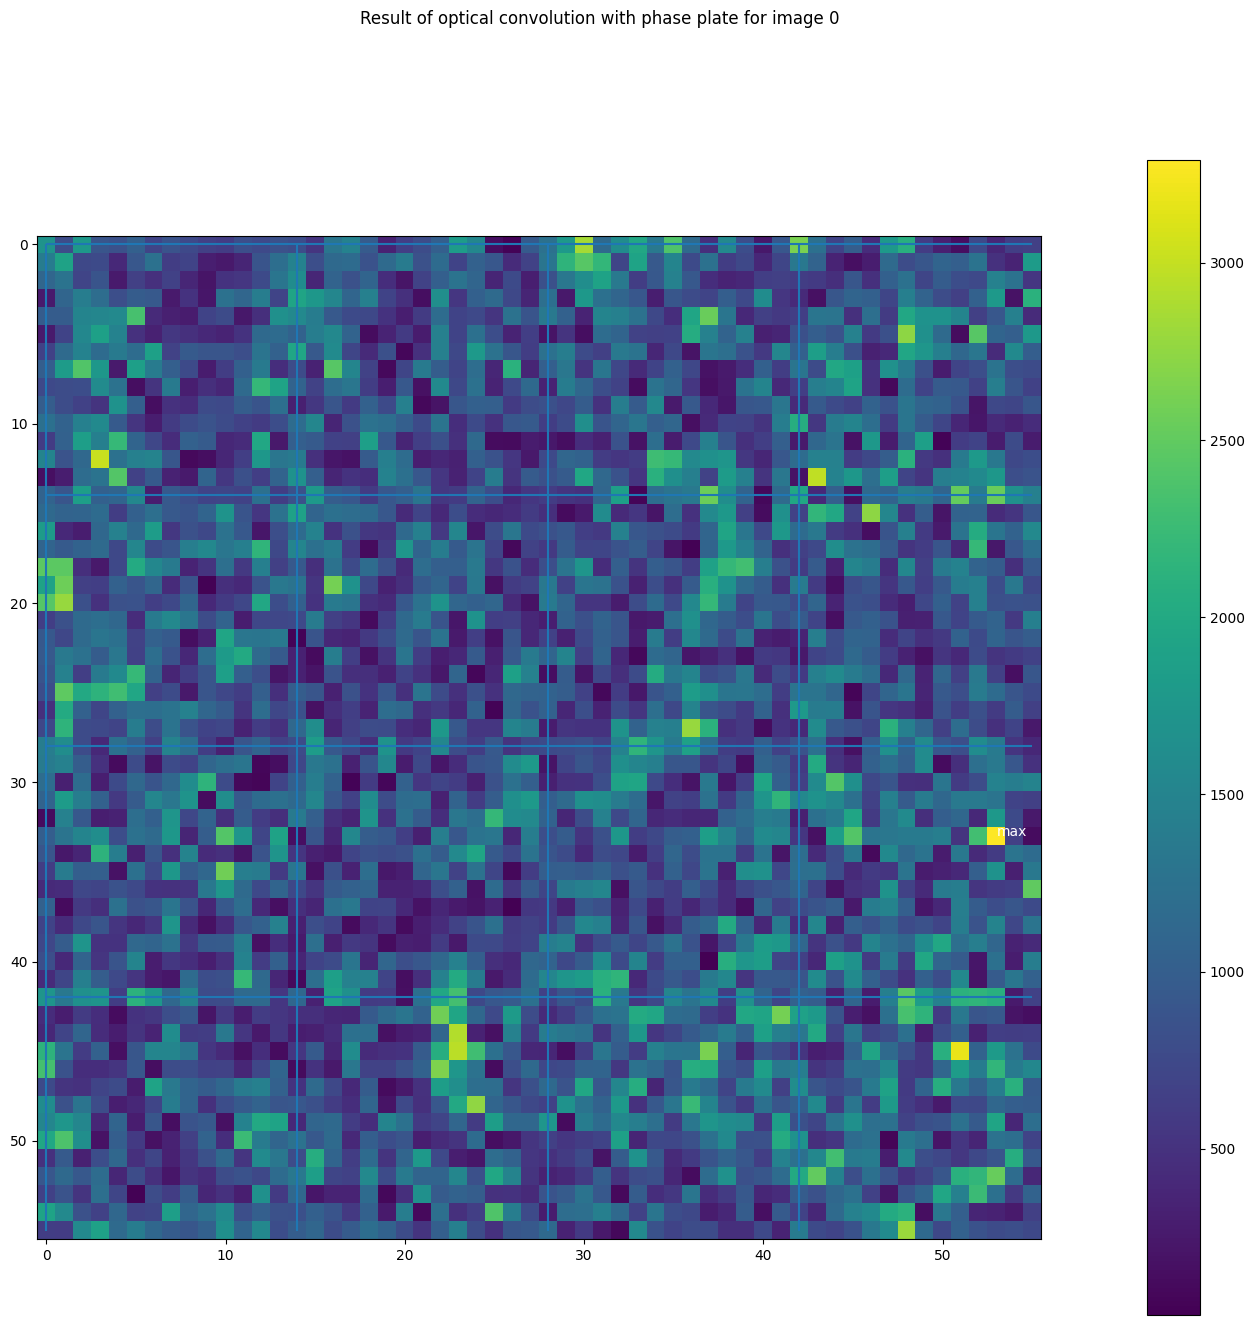

In [54]:
for idx, psf in enumerate(convolved):
    psf = psf.squeeze().cpu()
    grid_to_depth = rearrange(
        psf,
        "(m ht) (n wt) -> (m n) ht wt",
        ht = model.tile_size*model.resolution_scale_factor,
        wt = model.tile_size*model.resolution_scale_factor,
        m = model.tiles_per_dim,
        n = model.tiles_per_dim
    )
    # 5
    grid_to_depth = unpad_zeros(
        grid_to_depth, 
        (model.kernel_size_pixels*model.resolution_scale_factor,  
         model.kernel_size_pixels*model.resolution_scale_factor))
    # 2
    grid_to_depth = pad_zeros(
        grid_to_depth, 
        size = (model.tile_size*model.resolution_scale_factor , 
                model.tile_size*model.resolution_scale_factor ),
    )
    grid_to_depth = rearrange(
        grid_to_depth,
        "(m n) ht wt -> (m ht) (n wt)",
        ht = model.tile_size*model.resolution_scale_factor,
        wt = model.tile_size*model.resolution_scale_factor,
        m = model.tiles_per_dim,
        n = model.tiles_per_dim
    )
    
    f, ax = imshow(grid_to_depth, figsize=(15,15), title=f"Result of optical convolution with phase plate for image {idx}")
    ax[0].hlines(np.arange(0, grid_to_depth.shape[0], grid_to_depth.shape[0]//model.tiles_per_dim), 0, psf.shape[1]-1)
    ax[0].vlines(np.arange(0, grid_to_depth.shape[1], grid_to_depth.shape[1]//model.tiles_per_dim), 0, psf.shape[0]-1)
    y,x = (psf==torch.max(grid_to_depth)).nonzero()[0]
    ax[0].text(x,y, "max", color='white');

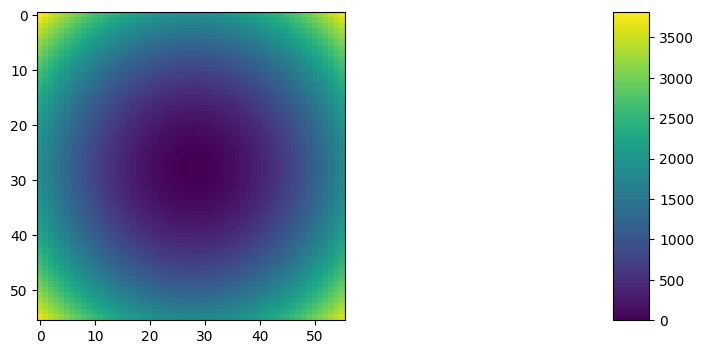

In [55]:
imshow(model.U.cpu());

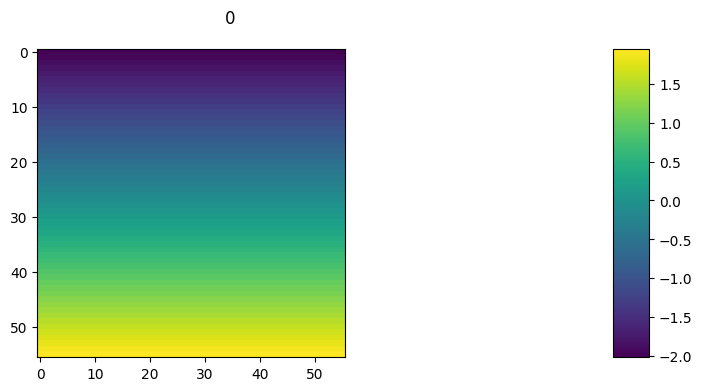

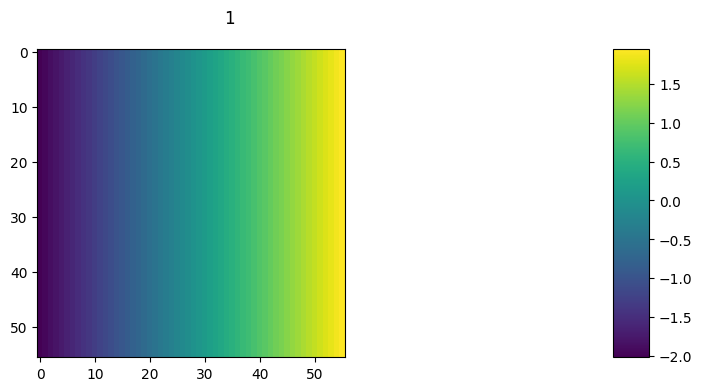

In [56]:
imshow([model.x, model.y]);

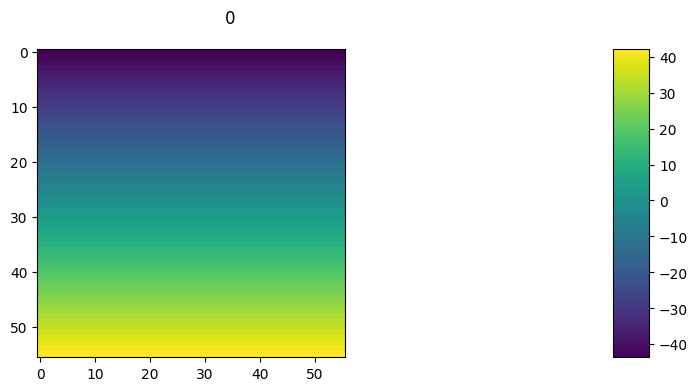

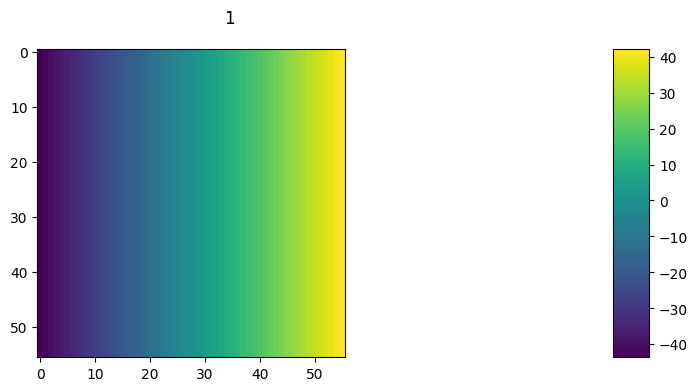

In [57]:
imshow([model.Kx, model.Ky]);

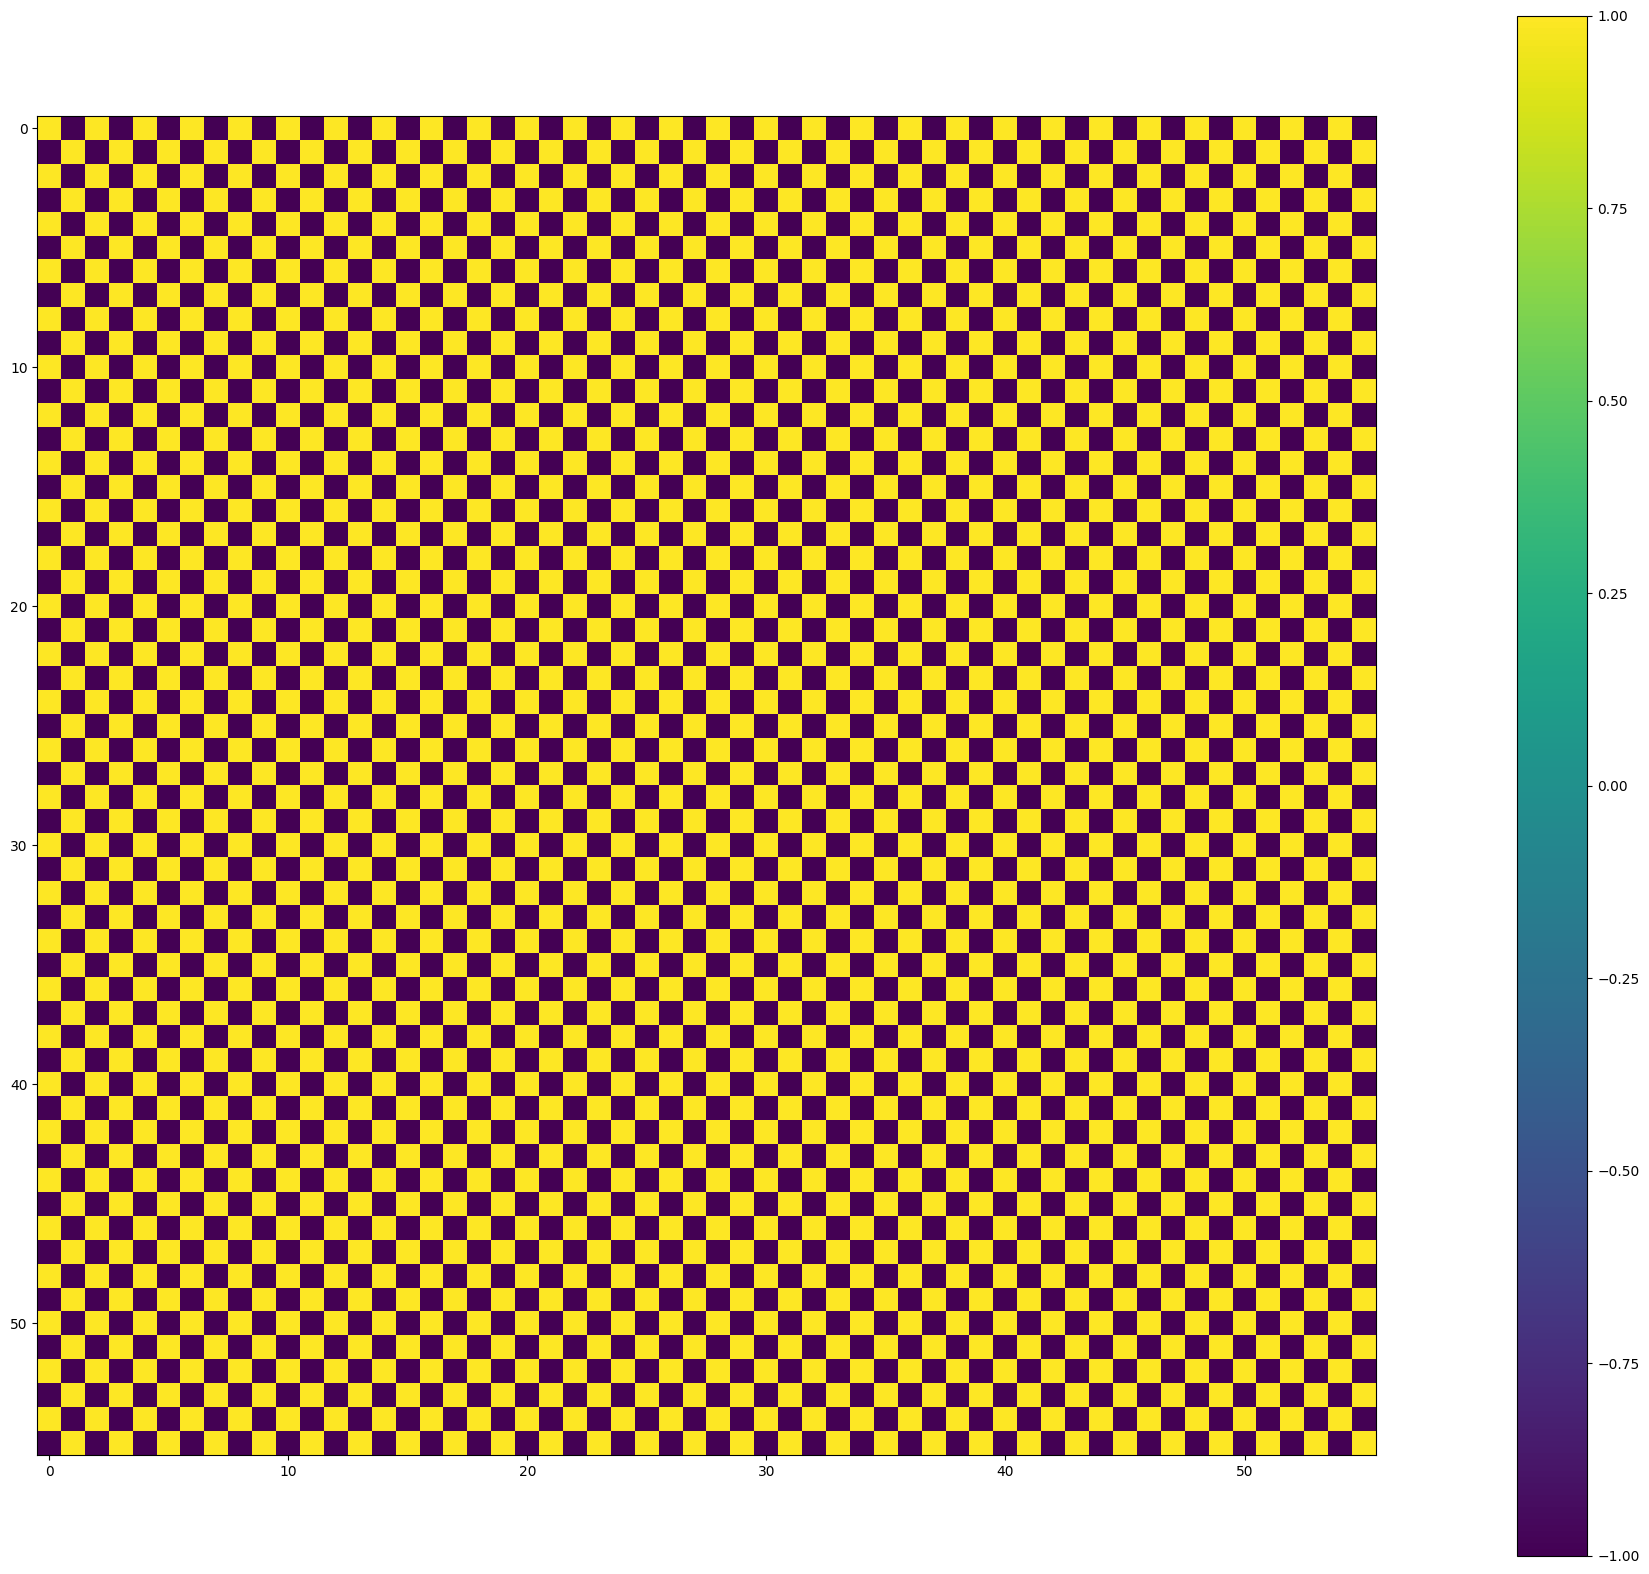

In [58]:
imshow(model.vv, figsize=(20,20));

In [ ]:
time.sleep(121)

In [90]:
Path(CONFIG.experiment_dir / f"{CONFIG.name_id}.ipynb").write_bytes(Path("Propagator_QuickDraw.ipynb").read_bytes());